In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [4]:
prefix_file = "drive/MyDrive/nlp/en_vi"

In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
def unicodeToAscii(s):
    return unicodedata.normalize('NFKC', s)  # Chuyển về dạng chuẩn mà không xóa dấu

# Không loại bỏ dấu tiếng Việt và giữ lại số
def normalizeString(s):
    s = s.lower().strip()  # Chuyển về chữ thường và loại bỏ khoảng trắng dư thừa

    # Thay thế các HTML phổ biến
    s = s.replace("&apos;", "'")
    s = s.replace("&quot;", "\"")

    # Giữ lại chữ cái, số, dấu câu và ký tự tiếng Việt
    s = re.sub(r"[^a-zA-Z0-9áàảãạăắằẳẵặâấầẩẫậđéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵ.!?,']+", " ", s)

    return s.strip()


In [7]:
def readLangs(src_file, tgt_file, lang1, lang2, reverse=False):
    print("Reading lines...")

    # Đọc file nguồn và đích
    with open(src_file, encoding='utf-8') as f_src, open(tgt_file, encoding='utf-8') as f_tgt:
        src_lines = f_src.read().strip().split('\n')
        tgt_lines = f_tgt.read().strip().split('\n')

    # Kiểm tra số lượng dòng phải khớp
    assert len(src_lines) == len(tgt_lines), "Số dòng trong file nguồn và đích không khớp!"
    print(len(src_lines))
    print(len(tgt_lines))
    # Tạo danh sách cặp câu
    pairs = [[normalizeString(src), normalizeString(tgt)] for src, tgt in zip(src_lines, tgt_lines)]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 20

# eng_prefixes = (
#     "i am ", "i m ",
#     "he is", "he s ",
#     "she is", "she s ",
#     "you are", "you re ",
#     "we are", "we re ",
#     "they are", "they re "
# )

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(f'{prefix_file}/train.src', f'{prefix_file}/train.tgt', lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



In [10]:
input_lang, output_lang, pairs = prepareData('eng', 'vie', True)
print(random.choice(pairs))

Reading lines...
133317
133317
Read 133317 sentence pairs
Trimmed to 64755 sentence pairs
Counting words...
Counted words:
vie 11750
eng 23896
['lòng trung thành khách hàng của chúng tôi tăng vọt .', 'our customer loyalty skyrocketed .']


## Seq2Seq Model

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.lstm(embedded)
        return output, hidden

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        return output, hidden

### Attention

In [13]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.lstm = nn.LSTM(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden[0].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)

        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

## Define Training

In [14]:
# prepare training data
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'vie', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [15]:
# train model
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
# plot result
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Define Evaluation

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Train and test

### without attention

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=1, plot_every=5)

Reading lines...
133317
133317
Read 133317 sentence pairs
Trimmed to 64755 sentence pairs
Counting words...
Counted words:
vie 11750
eng 23896
0m 59s (- 78m 43s) (1 1%) 2.8914
1m 54s (- 74m 34s) (2 2%) 2.3791
2m 50s (- 72m 52s) (3 3%) 2.1858
3m 46s (- 71m 39s) (4 5%) 2.0485
4m 41s (- 70m 17s) (5 6%) 1.9383
5m 35s (- 69m 3s) (6 7%) 1.8446
6m 30s (- 67m 54s) (7 8%) 1.7637
7m 26s (- 66m 58s) (8 10%) 1.6919
8m 21s (- 65m 57s) (9 11%) 1.6288
9m 16s (- 64m 56s) (10 12%) 1.5719
10m 11s (- 63m 54s) (11 13%) 1.5221
11m 5s (- 62m 53s) (12 15%) 1.4770
12m 1s (- 62m 0s) (13 16%) 1.4360
12m 56s (- 61m 0s) (14 17%) 1.3989
13m 51s (- 60m 3s) (15 18%) 1.3643
14m 46s (- 59m 7s) (16 20%) 1.3324
15m 42s (- 58m 11s) (17 21%) 1.3032
16m 36s (- 57m 13s) (18 22%) 1.2757
17m 31s (- 56m 15s) (19 23%) 1.2498
18m 25s (- 55m 17s) (20 25%) 1.2261
19m 21s (- 54m 23s) (21 26%) 1.2039
20m 17s (- 53m 28s) (22 27%) 1.1830
21m 11s (- 52m 31s) (23 28%) 1.1629
22m 6s (- 51m 34s) (24 30%) 1.1445
23m 1s (- 50m 38s) (25 31%)

In [21]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# train(train_dataloader, encoder, decoder, 80, print_every=1, plot_every=5)

Reading lines...
133317
133317
Read 133317 sentence pairs
Trimmed to 64755 sentence pairs
Counting words...
Counted words:
vie 11750
eng 23896


In [22]:
encoder.load_state_dict(torch.load("encoder_model.pth"))
decoder.load_state_dict(torch.load("decoder_model.pth"))
# Save encoder and decoder models
# torch.save(encoder.state_dict(), "encoder_model.pth")
# torch.save(decoder.state_dict(), "decoder_model.pth")
# print("Models have been saved.")

encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

<ipython-input-22-4edafacb0d63>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("encoder_model.pth"))
<ipython-input-22-4edafacb0d63>:2: 

> nhưng ông khá cố chấp đối với âm nhạc .
= but he was tough when it came to music .
< but bear seemed to affect music that i was . <EOS>

> chúng như một dạng bảo hiểm .
= they actually act like an insurance .
< they like a very different . <EOS>

> đến một lúc nào đó , mình sẽ thoát khỏi đây .
= at some point i 'm going to get out .
< there was a while , i 'll just throw it back . <EOS>

> nói một cách nhẹ nhàng thì tôi học không được tốt cho lắm .
= to put it mildly , i didn 't do very well .
< to me , i don 't even see a very good job . <EOS>

> tôi đã tìm hiểu sâu về bản ghép .
= i got into fish .
< i was trying to understand my interests . <EOS>

> tôi đã đọc những tác phẩm của sartre và socrates .
= i read sartre and socrates .
< i read sartre and socrates . <EOS>

> trên thực tế , kết quả đầu tiên đã làm tôi rất , rất , rất thất vọng .
= actually , the first results were very , very , very disappointing .
< in fact , in fact , i was very first really , very much of us first , t

In [29]:
# def showAttention(input_sentence, output_words, attentions):
#     import matplotlib.pyplot as plt
#     import matplotlib.ticker as ticker

#     fig = plt.figure(figsize=(10, 10))  # Đặt kích thước biểu đồ
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Tách từ trong input_sentence và output_words
#     input_words = input_sentence.split(' ') + ['<EOS>']
#     output_words_with_eos = output_words + ['<EOS>']

#     # Set số lượng tick dựa trên số lượng từ
#     ax.set_xticks(range(len(input_words)))  # Tick trên trục x
#     ax.set_yticks(range(len(output_words_with_eos)))  # Tick trên trục y

#     # Gán nhãn tick
#     ax.set_xticklabels(input_words, rotation=90)  # Nhãn trục x
#     ax.set_yticklabels(output_words_with_eos)  # Nhãn trục y

#     plt.show()


def evaluateSentence(input_sentence):
    output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateSentence('tôi yêu bạn')
evaluateSentence('tên bạn là gì')
evaluateSentence('tất cả những gì bạn phải làm là đọc to những gì bạn nhìn thấy , được không ?')
evaluateSentence('đúng không ? nó tiếp nhận thông tin . nó hình thành hành vi có ích .')
evaluateSentence('ngay cả bệnh say sóng cũng là một hậu quả của sự không chắc chắn .')

input = tôi yêu bạn
output = i love you . <EOS>
input = tên bạn là gì
output = your ideal body was there . <EOS>
input = tất cả những gì bạn phải làm là đọc to những gì bạn nhìn thấy , được không ?
output = all you have to see , you know what you 're doing , what was wrong ? <EOS>
input = đúng không ? nó tiếp nhận thông tin . nó hình thành hành vi có ích .
output = right ? it 's the bottom of the information that 's going to be buying and become a false course
input = ngay cả bệnh say sóng cũng là một hậu quả của sự không chắc chắn .
output = even seasickness is a consequence of uncertainty . <EOS>


### test

In [ ]:
def prepareTestData(test_src_file, test_tgt_file, input_lang, output_lang):
    _, _, pairs = readLangs(test_src_file, test_tgt_file, input_lang.name, output_lang.name, reverse=True)
    print("Read %s test sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Filtered to %s test sentence pairs" % len(pairs))
    return pairs
test_pairs = prepareTestData(f'{prefix_file}/test.src', f'{prefix_file}/test.tgt', input_lang, output_lang)
print(random.choice(test_pairs))


Reading lines...
1553
1553
Read 1553 test sentence pairs
Filtered to 795 test sentence pairs
['tôi bảo mẹ là tôi không thể làm được .', "i told my mother i couldn 't do it ."]


In [42]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluateWithBLEU(encoder, decoder, test_pairs, input_lang, output_lang):
    scores = []

    for pair in test_pairs:
        input_sentence, target_sentence = pair

        # Kiểm tra xem tất cả các từ trong câu có nằm trong từ điển không
        if all(word in input_lang.word2index for word in input_sentence.split(' ')):
            # Nếu tất cả các từ có trong từ điển, tiến hành dịch câu
            output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
            output_sentence = ' '.join(output_words)

            reference = [target_sentence.split()]  # Chuẩn bị câu mục tiêu
            candidate = output_sentence.split()  # Chuẩn bị câu dự đoán

            score = sentence_bleu(reference, candidate)
            scores.append(score)
        else:
            print(f"Skipping sentence due to unknown words: {input_sentence}")

    if scores:
        print(f'Average BLEU score: {sum(scores) / len(scores):.4f}')
    else:
        print("No valid sentences for BLEU score.")


In [44]:
test_pairs = prepareTestData(f'{prefix_file}/test.src', f'{prefix_file}/test.tgt', input_lang, output_lang)
# evaluateOnTestSet(encoder, decoder, test_pairs, input_lang, output_lang)
evaluateWithBLEU(encoder, decoder, pairs[:5000], input_lang, output_lang)


Reading lines...
1553
1553
Read 1553 test sentence pairs
Filtered to 795 test sentence pairs


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU score: 0.1194


### with attention

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder_attention = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_attention = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder_attention, decoder_attention, 80, print_every=5, plot_every=5)

Reading lines...
133317
133317
Read 133317 sentence pairs
Trimmed to 64755 sentence pairs
Counting words...
Counted words:
vie 11750
eng 23896
7m 35s (- 113m 45s) (5 6%) 2.1631
15m 1s (- 105m 10s) (10 12%) 1.4951
22m 28s (- 97m 23s) (15 18%) 1.2081
29m 55s (- 89m 46s) (20 25%) 1.0475
37m 21s (- 82m 11s) (25 31%) 0.9453
44m 47s (- 74m 39s) (30 37%) 0.8735
52m 16s (- 67m 12s) (35 43%) 0.8190
59m 51s (- 59m 51s) (40 50%) 0.7757
67m 19s (- 52m 21s) (45 56%) 0.7411
74m 46s (- 44m 51s) (50 62%) 0.7117
82m 17s (- 37m 24s) (55 68%) 0.6874
89m 46s (- 29m 55s) (60 75%) 0.6657
97m 14s (- 22m 26s) (65 81%) 0.6471
104m 42s (- 14m 57s) (70 87%) 0.6306
112m 13s (- 7m 28s) (75 93%) 0.6154
119m 42s (- 0m 0s) (80 100%) 0.6025


In [25]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder_attention = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_attention = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# train(train_dataloader, encoder_attention, decoder_attention, 80, print_every=5, plot_every=5)

Reading lines...
133317
133317
Read 133317 sentence pairs
Trimmed to 64755 sentence pairs
Counting words...
Counted words:
vie 11750
eng 23896


In [31]:
encoder_attention.load_state_dict(torch.load("encoder_attention_model.pth"))
decoder_attention.load_state_dict(torch.load("decoder_attention_model.pth"))
# torch.save(encoder_attention.state_dict(), "encoder_attention_model.pth")
# torch.save(decoder_attention.state_dict(), "decoder_attention_model.pth")
encoder_attention.eval()
decoder_attention.eval()
evaluateRandomly(encoder_attention, decoder_attention)

> carolyn steel thực phẩm định hình các thành phố như thế nào
= carolyn steel how food shapes our cities
< carolyn steel how genetic food is the cities that 's how the city <EOS>

> và chúng tôi muốn làm sao để cảnh giác mọi người ?
= and we wanted to do how can we best alert everyone ?
< and we wanted to do that what do you think ? <EOS>

> từ thứ năm tôi đã mong đến cuối tuần rồi .
= i likely already look forward to the weekend on thursdays .
< so my time i had been proposed to last weekend . <EOS>

> chúng làm điều đó như thế nào ?
= how do they do that ?
< how do we do that ? <EOS>

> những nghiên cứu này bị thiếu sót gì đó .
= there 's something missing from these studies .
< what causes in missing sense there . <EOS>

> giờ ta cần đưa nó vào thực tế .
= now we need to get this thing into practice .
< now we need to put it into real real time . <EOS>

> thay vì nhảy ra khỏi máy bay đúng không ?
= so instead of jumping off a plane , yes ?
< instead of pulling the verb to the plane 

<ipython-input-31-269419648d19>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_attention.load_state_dict(torch.load("encoder_attention_model.pth"))
<ipython-input-

input = tôi yêu bạn
output = i love you . <EOS>


<ipython-input-48-ee0ae4cdc7a8>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-48-ee0ae4cdc7a8>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


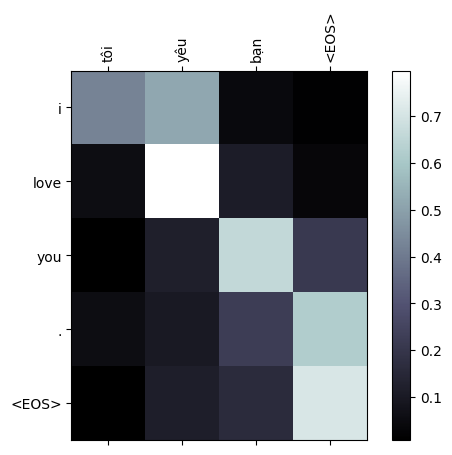

input = tên bạn là gì
output = what is your name ? <EOS>


<ipython-input-48-ee0ae4cdc7a8>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-48-ee0ae4cdc7a8>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


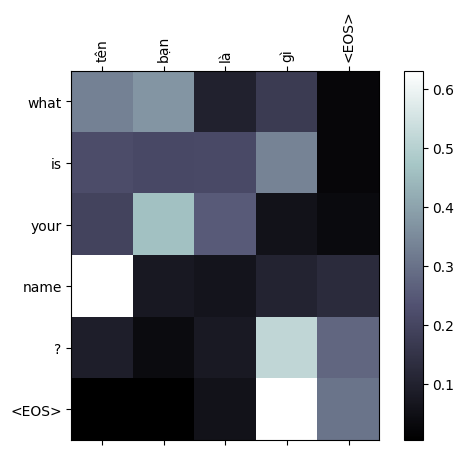

input = tất cả những gì bạn phải làm là đọc to những gì bạn nhìn thấy , được không ?
output = all you have to do is read what you see , okay ? <EOS>


<ipython-input-48-ee0ae4cdc7a8>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-48-ee0ae4cdc7a8>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


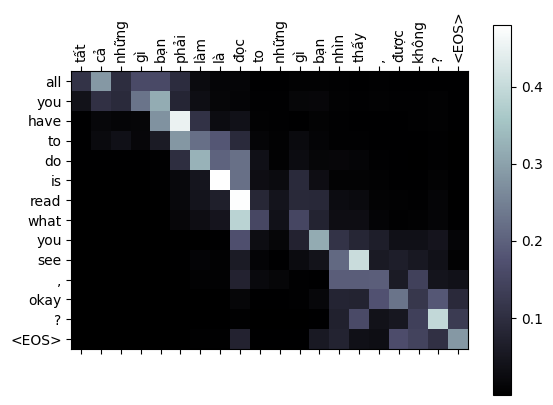

input = đúng không ? nó tiếp nhận thông tin . nó hình thành hành vi có ích .
output = right ? it 's directly information . it 's generating behavior that 's useful . <EOS>


<ipython-input-48-ee0ae4cdc7a8>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-48-ee0ae4cdc7a8>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


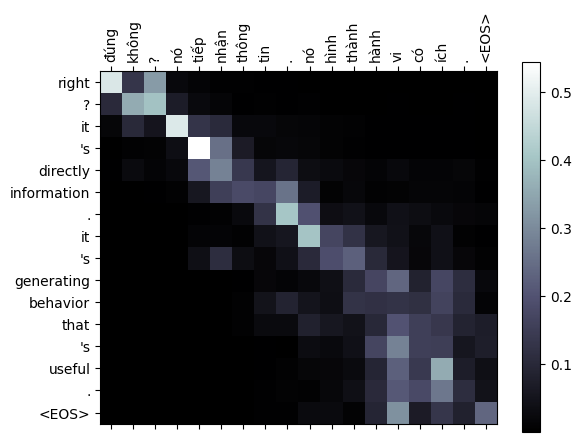

input = ngay cả bệnh say sóng cũng là một hậu quả của sự không chắc chắn .
output = even seasickness is a consequence of uncertainty . <EOS>


<ipython-input-48-ee0ae4cdc7a8>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-48-ee0ae4cdc7a8>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


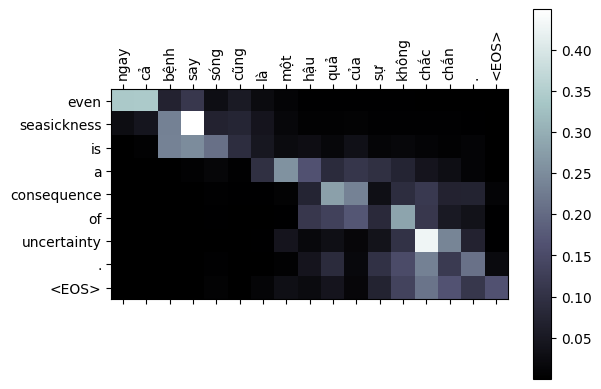

input = tôi nhìn qua tấm kính cửa và thấy bà đứng ở bên kia
output = i looked at the glass of a window and she saw on the other side . <EOS>


<ipython-input-48-ee0ae4cdc7a8>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-48-ee0ae4cdc7a8>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


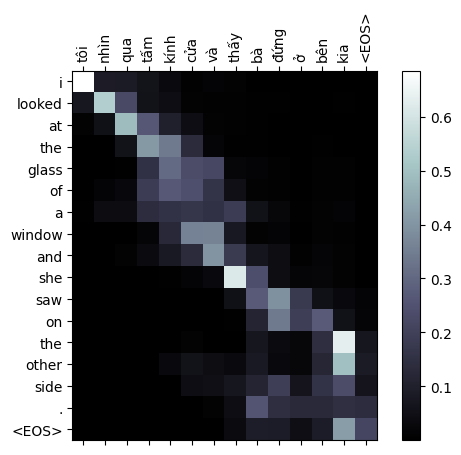

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder_attention, decoder_attention, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # print(attentions)
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])



evaluateAndShowAttention('tôi yêu bạn')
evaluateAndShowAttention('tên bạn là gì')
evaluateAndShowAttention('tất cả những gì bạn phải làm là đọc to những gì bạn nhìn thấy , được không ?')
evaluateAndShowAttention('đúng không ? nó tiếp nhận thông tin . nó hình thành hành vi có ích .')
evaluateAndShowAttention('ngay cả bệnh say sóng cũng là một hậu quả của sự không chắc chắn .')
evaluateAndShowAttention('tôi nhìn qua tấm kính cửa và thấy bà đứng ở bên kia')

In [34]:
def prepareTestData(test_src_file, test_tgt_file, input_lang, output_lang):
    _, _, pairs = readLangs(test_src_file, test_tgt_file, input_lang.name, output_lang.name, reverse=True)
    print("Read %s test sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Filtered to %s test sentence pairs" % len(pairs))
    return pairs
test_pairs = prepareTestData(f'{prefix_file}/test.src', f'{prefix_file}/test.tgt', input_lang, output_lang)
print(random.choice(test_pairs))


Reading lines...
1553
1553
Read 1553 test sentence pairs
Filtered to 795 test sentence pairs
['tôi nhìn qua tấm kính cửa và thấy bà đứng ở bên kia', 'i looked through the shower screen and saw her standing on the other side .']


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluateWithBLEU(encoder, decoder, test_pairs, input_lang, output_lang):
    scores = []
    smoothing_function = SmoothingFunction().method1  # Thêm smoothing function

    for pair in test_pairs:
        input_sentence, target_sentence = pair

        # Kiểm tra xem tất cả các từ trong câu có nằm trong từ điển không
        if all(word in input_lang.word2index for word in input_sentence.split(' ')):
            # Nếu tất cả các từ có trong từ điển, tiến hành dịch câu
            output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
            output_sentence = ' '.join(output_words)

            reference = [target_sentence.split()]  # Chuẩn bị câu mục tiêu
            candidate = output_sentence.split()  # Chuẩn bị câu dự đoán

            # Tính điểm BLEU với smoothing function
            score = sentence_bleu(reference, candidate, smoothing_function=smoothing_function)
            scores.append(score)
        else:
            print(f"Skipping sentence due to unknown words: {input_sentence}")

    if scores:
        print(f'Average BLEU score: {sum(scores) / len(scores):.4f}')
    else:
        print("No valid sentences for BLEU score.")

In [47]:
test_pairs = prepareTestData(f'{prefix_file}/valid.src', f'{prefix_file}/valid.tgt', input_lang, output_lang)
# evaluateOnTestSet(encoder, decoder, test_pairs, input_lang, output_lang)
evaluateWithBLEU(encoder_attention, decoder_attention, pairs[:5000], input_lang, output_lang)


Reading lines...
1268
1268
Read 1268 test sentence pairs
Filtered to 518 test sentence pairs


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU score: 0.2680
